# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import random
import torch


In [2]:
VIS_ENABLED=False

if VIS_ENABLED:
    env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64", worker_id=random.randint(0,100))
else:
    env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64", worker_id=random.randint(0,100))
        
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [4]:
%load_ext autoreload
%autoreload 2
from ddpg_agent import Agent

agent = Agent(state_size          = state_size, 
              action_size         = action_size, 
              random_seed         = 2, 
              buffer_size         = 100000,
              batch_size          = 128,
              gamma               = 0.99,
              tau                 = 1e-3,
              lr_actor            = 2e-4,
              lr_critic           = 2e-4,
              actor_weight_decay  = 0,
              critic_weight_decay = 0,
              learn_prescaler     = 20, 
              learning_cycles     = 10, 
              noise_initial_gain  = 1.0,
              noise_gain_decay    = 1.0,
              sample_every_cycle  = True, 
              gradient_limiter    = True)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
def ddpg(n_episodes=10000, max_t=10000, print_every=100):   
    scores_deque = deque(maxlen=print_every)
    scores = []

    
    for i_episode in range(1, n_episodes+1):
        
        states = env.reset(train_mode=True)[brain_name].vector_observations     # reset the environment    
        agent.reset()
        
        scores_episode = np.zeros(num_agents)               # rewards per episode for each agent
        
        for t in range( max_t ):
            actions     = agent.act(states)
            env_info    = env.step(actions)[brain_name]     # send all actions to tne environment
            next_states = env_info.vector_observations      # get next state (for each agent)
            rewards     = env_info.rewards                  # get reward (for each agent)
            dones       = env_info.local_done               # see if episode finished
            
            for (state, action, reward, next_state, done) in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            
            states = next_states
            scores_episode += rewards
            
            if any(dones):
                break 
                
        
        #Averaring the mean score across all agents for this episode
        ep_score = np.max( scores_episode )

        scores.append( ep_score )
        scores_deque.append( ep_score )
        
        
        print('\rEpisode {}\tAverage Score: {:.5f}'.format(i_episode, np.mean( scores_deque )), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}'.format(i_episode, np.mean( scores_deque )))
            
    return scores

scores = ddpg()

Episode 5	Average Score: 0.00000

/home/bmendonca/workspace/udacity/deep-reinforcement-learning/p3_collab-compet/ddpg_agent.py:171: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 0.00090
Episode 200	Average Score: 0.00000
Episode 300	Average Score: 0.00000
Episode 400	Average Score: 0.00000
Episode 500	Average Score: 0.00000
Episode 600	Average Score: 0.00000
Episode 700	Average Score: 0.00000
Episode 800	Average Score: 0.00000
Episode 900	Average Score: 0.00000
Episode 1000	Average Score: 0.00000
Episode 1100	Average Score: 0.00000
Episode 1200	Average Score: 0.00190
Episode 1300	Average Score: 0.00000
Episode 1400	Average Score: 0.00000
Episode 1500	Average Score: 0.00100
Episode 1600	Average Score: 0.00000
Episode 1700	Average Score: 0.00780
Episode 1800	Average Score: 0.01730
Episode 1900	Average Score: 0.02370
Episode 2000	Average Score: 0.00790
Episode 2100	Average Score: 0.00100
Episode 2200	Average Score: 0.00100
Episode 2300	Average Score: 0.00000
Episode 2400	Average Score: 0.01560
Episode 2500	Average Score: 0.04590
Episode 2600	Average Score: 0.05430
Episode 2700	Average Score: 0.32930
Episode 2800	Average Score: 0.38990
E

When finished, you can close the environment.

In [6]:
env.close()

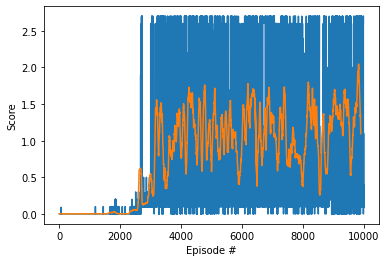

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

mean_score = moving_average( scores, 100 )

plt.plot( mean_score )
plt.show()